In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports 
import torch
from torch.utils.data import DataLoader
from torch.distributions.mixture_same_family import MixtureSameFamily
import torch.distributions as D
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Internal imports
import sys; sys.path.insert(0, '..')
from src import *

In [3]:
N_DIMS = 1
NUM_SAMPLES = 20000
BS = 500
NUM_EPOCHS = 1000
SEED = 10
LR = 1e-2
DROPOUT = 0.20
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'


# Break by changing num datapoints, scales, means, or to 2D

In [4]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
# Define model
model_cob = RatioCritic1D_K3(dim_input=N_DIMS, dim_output=3, dropout=DROPOUT)
# model.apply(weights_init)

# Define optimizer
optim_cob = torch.optim.Adam(model_cob.parameters(), lr=LR)

# Define distributions
p, q, m = get_dists_1d_cob(mu1=-1., mu2=1., mu3=0, scale_p=0.1, scale_q=0.2, alphas=[0.25, 0.50, 0.75])

# -5, 5, m_var=3.0
# -10, 10, m_var=3.0

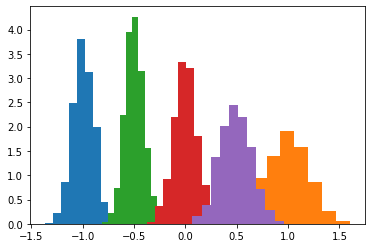

In [6]:
m1, m2, m3 = m
p_samples = p.sample([1000])
q_samples = q.sample([1000])
m1_samples = m1.sample([1000])
m2_samples = m2.sample([1000])
m3_samples = m3.sample([1000])

plt.hist(p_samples.numpy(), density=True, histtype='stepfilled')
plt.hist(q_samples.numpy(), density=True, histtype='stepfilled')
plt.hist(m1_samples.numpy(), density=True, histtype='stepfilled')
plt.hist(m2_samples.numpy(), density=True, histtype='stepfilled')
plt.hist(m3_samples.numpy(), density=True, histtype='stepfilled')
plt.show()

In [7]:
# Define dataset & dataloader
train_ds = DistDataset3Waymark(p, q, m, num_samples=NUM_SAMPLES)
test_ds = DistDataset3Waymark(p, q, m, num_samples=NUM_SAMPLES) # Test dataset is only of size batch 

Sampling p
Sampling q
torch.Size([20000])
torch.Size([20000])
torch.Size([20000])
torch.Size([20000])
torch.Size([20000])
Sampling p
Sampling q
torch.Size([20000])
torch.Size([20000])
torch.Size([20000])
torch.Size([20000])
torch.Size([20000])


In [8]:
# Define dataloader
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BS, shuffle=True)

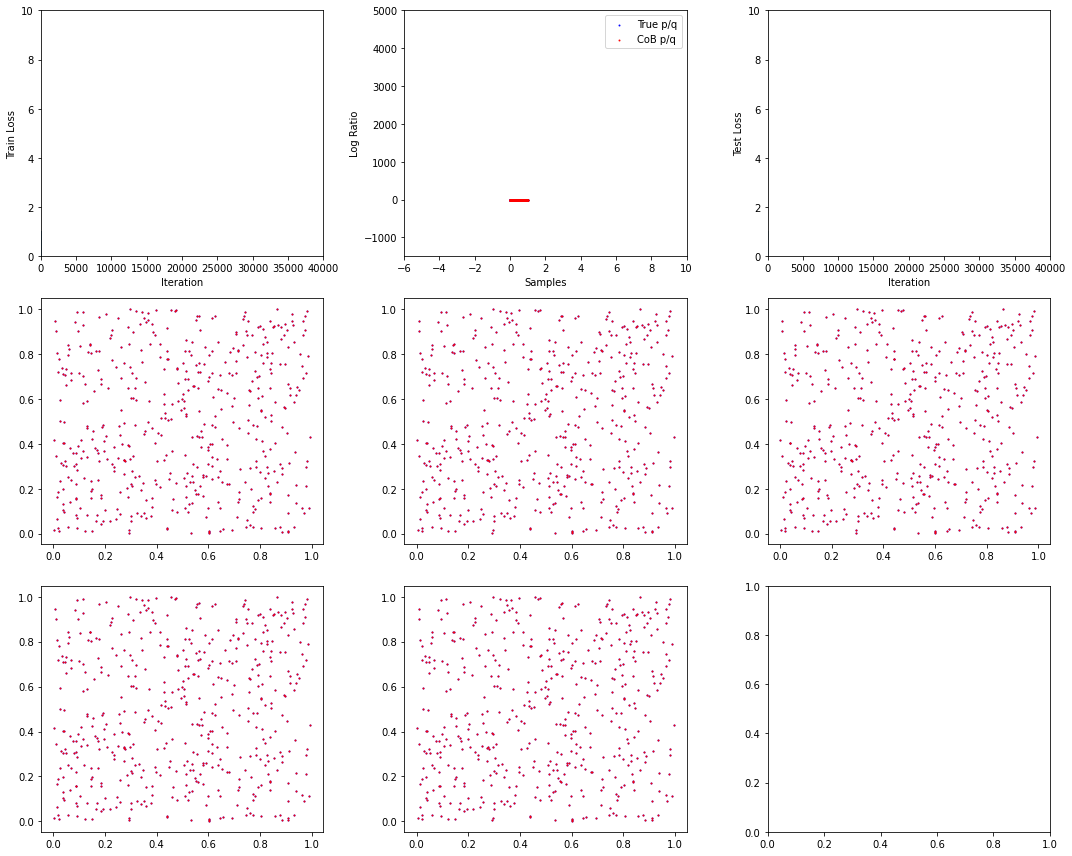

In [9]:
# Set up viz
fig, [[ax1,ax2,ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(3, 3,figsize=(15,12))

line, = ax1.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=1.,c='b')
scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=1.,c='r')
test_line, = ax3.plot([0,1],[0,1])

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax1.set_ylim([0,10])

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([-6,10])
ax2.set_ylim([-1500,5000])

ax3.set_xlabel("Iteration")
ax3.set_ylabel("Test Loss")
ax3.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax3.set_ylim([0,10])

scat3 = ax4.scatter(x,y,label='True p/q from p',alpha=0.9,s=1.,c='b')
scat4 = ax4.scatter(x,y,label='CoB p/q from p',alpha=0.9,s=1.,c='r')

scat5 = ax5.scatter(x,y,label='True p/q from m1',alpha=0.9,s=1.,c='b')
scat6 = ax5.scatter(x,y,label='CoB p/q from m2',alpha=0.9,s=1.,c='r')

scat7 = ax6.scatter(x,y,label='True p/q from m2',alpha=0.9,s=1.,c='b')
scat8 = ax6.scatter(x,y,label='CoB p/q from m2',alpha=0.9,s=1.,c='r')

scat9 = ax7.scatter(x,y,label='True p/q from m3',alpha=0.9,s=1.,c='b')
scat10 = ax7.scatter(x,y,label='CoB p/q from m3',alpha=0.9,s=1.,c='r')

scat11 = ax8.scatter(x,y,label='True p/q from q',alpha=0.9,s=1.,c='b')
scat12 = ax8.scatter(x,y,label='CoB p/q from q',alpha=0.9,s=1.,c='r')

plt.tight_layout()

loss_store = []
test_loss_store = []

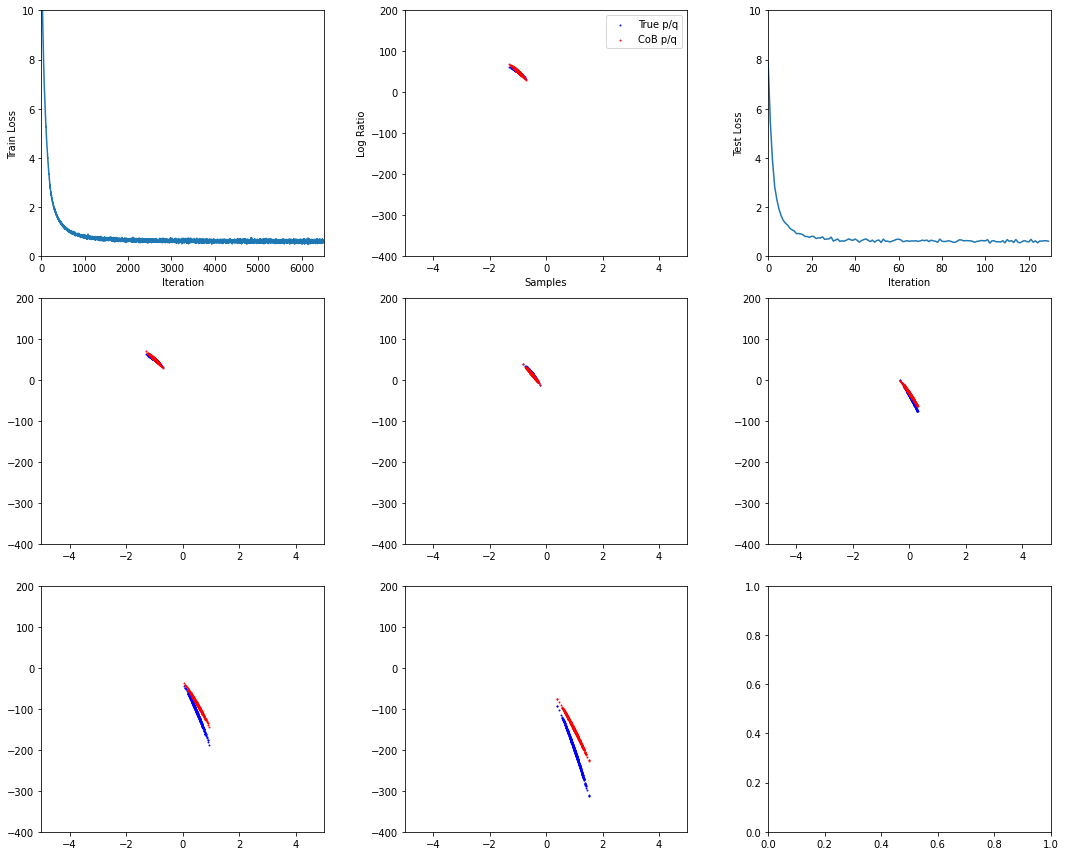

  4%|▍         | 45/1000 [01:16<27:02,  1.70s/it]


KeyboardInterrupt: 

In [12]:
## CONFIRM q_list_test in validation/visualization in Akash's code

model_cob.train()

if torch.cuda.is_available():
    model_cob = model_cob.to(DEVICE)
    
i = 0
# loss_crit = torch.nn.CrossEntropyLoss()
loss_crit_cob = torch.nn.functional.cross_entropy


for epoch in trange(NUM_EPOCHS):
    for p_batch, q_batch, m_batch1, m_batch2, m_batch3 in iter(train_dl):
        model_cob.train()
        
        i += 1
        
        optim_cob.zero_grad()
        
        # CUDA
        if torch.cuda.is_available():
            p_batch, q_batch, m_batch1, m_batch2, m_batch3 = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch1.unsqueeze(1).to(DEVICE), m_batch2.unsqueeze(1).to(DEVICE), m_batch3.unsqueeze(1).to(DEVICE)
            
        logP = model_cob(p_batch)
        logQ = model_cob(q_batch)
        logM1 = model_cob(m_batch1)
        logM2 = model_cob(m_batch2)
        logM3 = model_cob(m_batch3)
        
        p_label = torch.empty(p_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
        q_label = torch.empty(q_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
        m1_label = torch.empty(m_batch1.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
        m2_label = torch.empty(m_batch2.shape[0], dtype=torch.long, device=DEVICE).fill_(3)
        m3_label = torch.empty(m_batch3.shape[0], dtype=torch.long, device=DEVICE).fill_(4)
        
        loss_cob = loss_crit_cob(logP, p_label) + loss_crit_cob(logQ, q_label) + loss_crit_cob(logM1, m1_label) + loss_crit_cob(logM2, m2_label) + loss_crit_cob(logM3, m3_label)
        loss_cob.backward()
        optim_cob.step()
        loss_store.append(loss_cob.item())

        # Validation/Test
        if i % 50 == 0:
            model_cob.eval()
            
            with torch.no_grad():
                for p_batch, q_batch, m_batch1, m_batch2, m_batch3 in iter(test_dl):
                    gt_lr_p_q_from_p, _, true_kl_p_q = get_gt_ratio_kl(p, q, p_batch, calc_true_kl=True)
                    gt_lr_p_q_from_m1, _ = get_gt_ratio_kl(p, q, m_batch1, calc_true_kl=False)
                    gt_lr_p_q_from_m2, _ = get_gt_ratio_kl(p, q, m_batch2, calc_true_kl=False)
                    gt_lr_p_q_from_m3, _ = get_gt_ratio_kl(p, q, m_batch3, calc_true_kl=False)
                    gt_lr_p_q_from_q, _ = get_gt_ratio_kl(p, q, q_batch, calc_true_kl=False)

                    if torch.cuda.is_available():
                        p_batch, q_batch, m_batch1, m_batch2, m_batch3 = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch1.unsqueeze(1).to(DEVICE), m_batch2.unsqueeze(1).to(DEVICE), m_batch3.unsqueeze(1).to(DEVICE)
                    
                    logP = model_cob(p_batch)
                    logQ = model_cob(q_batch)
                    logM1 = model_cob(m_batch1)
                    logM2 = model_cob(m_batch2)
                    logM3 = model_cob(m_batch3)

                    p_label = torch.empty(p_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
                    q_label = torch.empty(q_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
                    m1_label = torch.empty(m_batch1.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
                    m2_label = torch.empty(m_batch2.shape[0], dtype=torch.long, device=DEVICE).fill_(3)
                    m3_label = torch.empty(m_batch3.shape[0], dtype=torch.long, device=DEVICE).fill_(4)

#                     log_ratio_p_q_from_cob = logP[:, 0] - logP[:, 1]
#                     kl_from_cob = torch.mean(log_ratio_p_q_from_cob)
                    
                    lr_p_q_cob_from_p = logP[:, 0] - logP[:, 1]
                    lr_p_q_cob_from_m1 = logM1[:, 0] - logM1[:, 1]
                    lr_p_q_cob_from_m2 = logM2[:, 0] - logM2[:, 1]
                    lr_p_q_cob_from_m3 = logM3[:, 0] - logM3[:, 1]
                    lr_p_q_cob_from_q = logQ[:, 0] - logQ[:, 1]                    
                    
                    test_loss_cob = loss_crit_cob(logP, p_label) + loss_crit_cob(logQ, q_label) + loss_crit_cob(logM1, m1_label) + loss_crit_cob(logM2, m2_label) + loss_crit_cob(logM3, m3_label)

                    # Visualize
                    line.set_data(range(len(loss_store)), loss_store)
                    ax1.set_xlim( 0, len(loss_store) )
                    
                    scat1.set_offsets(np.vstack([p_batch.cpu().squeeze(), gt_lr_p_q_from_p.cpu().detach()]).T)
                    scat2.set_offsets(np.vstack([p_batch.cpu().squeeze(), lr_p_q_cob_from_p.cpu().detach()]).T)
                    ax2.set_xlim( -5., 5. )
                    ax2.set_ylim( -400, 200)
                    
                    scat3.set_offsets(np.vstack([p_batch.cpu().squeeze(), gt_lr_p_q_from_p.cpu().detach()]).T)
                    scat4.set_offsets(np.vstack([p_batch.cpu().squeeze(), lr_p_q_cob_from_p.cpu().detach()]).T)
                    ax4.set_xlim( -5., 5. )
                    ax4.set_ylim( -400, 200)
                    
                    scat5.set_offsets(np.vstack([m_batch1.cpu().squeeze(), gt_lr_p_q_from_m1.cpu().detach()]).T)
                    scat6.set_offsets(np.vstack([m_batch1.cpu().squeeze(), lr_p_q_cob_from_m1.cpu().detach()]).T)
                    ax5.set_xlim( -5., 5. )
                    ax5.set_ylim( -400, 200)
                    
                    scat7.set_offsets(np.vstack([m_batch2.cpu().squeeze(), gt_lr_p_q_from_m2.cpu().detach()]).T)
                    scat8.set_offsets(np.vstack([m_batch2.cpu().squeeze(), lr_p_q_cob_from_m2.cpu().detach()]).T)
                    ax6.set_xlim( -5., 5. )
                    ax6.set_ylim( -400, 200)
                    
                    scat9.set_offsets(np.vstack([m_batch3.cpu().squeeze(), gt_lr_p_q_from_m3.cpu().detach()]).T)
                    scat10.set_offsets(np.vstack([m_batch3.cpu().squeeze(), lr_p_q_cob_from_m3.cpu().detach()]).T)
                    ax7.set_xlim( -5., 5. )
                    ax7.set_ylim( -400, 200)
                    
                    scat11.set_offsets(np.vstack([q_batch.cpu().squeeze(), gt_lr_p_q_from_q.cpu().detach()]).T)
                    scat12.set_offsets(np.vstack([q_batch.cpu().squeeze(), lr_p_q_cob_from_q.cpu().detach()]).T)
                    ax8.set_xlim( -5., 5. )
                    ax8.set_ylim( -400, 200)
            
                    test_loss_store.append(test_loss_cob.item())
                    test_line.set_data(range(len(test_loss_store)), test_loss_store)
                    ax3.set_xlim( 0, len(test_loss_store) )
                    
                    clear_output(wait=True)
                    display(fig)
                    break

            model_cob.train()

In [11]:
torch.save({
    'model': model_cob.state_dict(),
    'optimizer': optim_cob.state_dict()
}, '1D_cob_best1.pth')

In [19]:
model_cob = RatioCritic1D_K3(dim_input=N_DIMS, dim_output=3, dropout=DROPOUT)

ckpt = torch.load('1D_cob_best.pth')
model_cob.load_state_dict(ckpt['model'])
model_cob = model_cob.to(DEVICE)

In [ ]:
                    print('iteration: ',i)
                    print('KLD: ', true_kl_p_q)
                    print('CoB: ', log_ratio_p_q_from_cob.mean())

In [15]:
m1, m2, m3 = m

In [16]:
m

[Normal(loc: -0.5, scale: 0.09013878554105759),
 Normal(loc: 0.0, scale: 0.11180339753627777),
 Normal(loc: 0.5, scale: 0.1520690619945526)]

In [17]:
def get_gt_log_ratios(p, q, m1, m2, m3, samples):
    p_lp = p.log_prob(samples.cpu())
    q_lp = q.log_prob(samples.cpu())
    m1_lp = m1.log_prob(samples.cpu())
    m2_lp = m2.log_prob(samples.cpu())
    m3_lp = m3.log_prob(samples.cpu())
    
#     return p_lp - q_lp,  p_lp - m1_lp, m1_lp - m2_lp, m2_lp - m3_lp, m3_lp - q_lp #p_lp - m_lp, q_lp - m_lp, m_lp - q_lp # p/q, p/m, q/m, m/q
    return p_lp - q_lp #, p_lp - m2_lp, q_lp - m2_lp, m1_lp - m2_lp, m3_lp - m2_lp
    

In [ ]:
def get_gt_log_ratios(p, q, m1, m2, m3, samples):
    p_lp = p.log_prob(samples.cpu())
    q_lp = q.log_prob(samples.cpu())
    m1_lp = m1.log_prob(samples.cpu())
    m2_lp = m2.log_prob(samples.cpu())
    m3_lp = m3.log_prob(samples.cpu())
    
#     return p_lp - q_lp,  p_lp - m1_lp, m1_lp - m2_lp, m2_lp - m3_lp, m3_lp - q_lp #p_lp - m_lp, q_lp - m_lp, m_lp - q_lp # p/q, p/m, q/m, m/q
    return p_lp - q_lp, m1_lp - q_lp, m2_lp - q_lp, m3_lp - q_lp

In [20]:
#######
with torch.no_grad():
    model_cob.eval()
    for p_batch, q_batch, m_batch1, m_batch2, m_batch3 in iter(test_dl):
        if torch.cuda.is_available():
            p_batch, q_batch, m_batch1, m_batch2, m_batch3 = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch1.unsqueeze(1).to(DEVICE), m_batch2.unsqueeze(1).to(DEVICE), m_batch3.unsqueeze(1).to(DEVICE)


        logP = model_cob(p_batch).cpu()
        logM1 = model_cob(m_batch1).cpu()
        logM2 = model_cob(m_batch2).cpu()
        logM3 = model_cob(m_batch3).cpu()
        logQ = model_cob(q_batch).cpu()

        log_ratio_p_q_from_cob_from_p = logP[:, 0] - logP[:, 1]
        log_ratio_p_q_from_cob_from_m1 = logM1[:, 0] - logM1[:, 1]
        log_ratio_p_q_from_cob_from_m2 = logM2[:, 0] - logM2[:, 1]
        log_ratio_p_q_from_cob_from_m3 = logM3[:, 0] - logM3[:, 1]
        log_ratio_p_q_from_cob_from_q = logQ[:, 0] - logQ[:, 1]
        
        true_log_ratio_p_q_from_p = get_gt_log_ratios(p, q, m1, m2, m3, p_batch)
        true_log_ratio_p_q_from_m1 = get_gt_log_ratios(p, q, m1, m2, m3, m_batch1)
        true_log_ratio_p_q_from_m2 = get_gt_log_ratios(p, q, m1, m2, m3, m_batch2)
        true_log_ratio_p_q_from_m3 = get_gt_log_ratios(p, q, m1, m2, m3, m_batch3)
        true_log_ratio_p_q_from_q = get_gt_log_ratios(p, q, m1, m2, m3, q_batch)
        break

In [ ]:
# Set up viz
fig, [ax1,ax2,ax3] = plt.subplots(1, 3,figsize=(8,3))
p_batch = p_batch.cpu()

scat1 = ax1.scatter(p_batch,true_log_ratio_p_q,label='True log p/q',alpha=0.9,s=10.,c='b')
scat2 = ax1.scatter(p_batch,log_ratio_p_q_from_cob_from_p,label='Multi-class K=3 log p/q',alpha=0.9,s=10.,c='r')

scat3 = ax2.scatter(p_batch,true_log_ratio_p_m,label='True log p/m',alpha=0.9,s=10.,c='b')
scat4 = ax2.scatter(p_batch,log_ratio_p_m_from_cob_from_p,label='Multi-class K=3 log p/m',alpha=0.9,s=10.,c='r')

scat5 = ax3.scatter(p_batch,true_log_ratio_q_m,label='True log q/m',alpha=0.9,s=10.,c='b')
scat6 = ax3.scatter(p_batch,log_ratio_q_m_from_cob_from_p,label='Multi-class K=3 log q/m',alpha=0.9,s=10.,c='r')

ylim = [-100, 150]
xlim = [-3, 3]
ax1.set_ylabel("Log Ratio")
ax1.legend(loc='best')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

ax3.set_ylabel("Log Ratio")
ax3.legend(loc='best')
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)

# ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.0)

plt.savefig('1D_demo_cob_K=1_p.png')

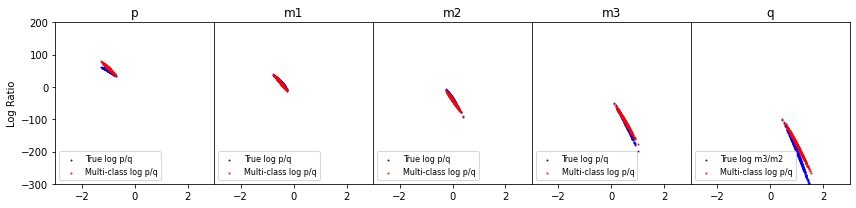

In [28]:
# Set up viz
fig, [ax1,ax2,ax3, ax4,ax5] = plt.subplots(1, 5,figsize=(12,3))
p_batch = p_batch.cpu()

scat1 = ax1.scatter(p_batch.cpu(),true_log_ratio_p_q_from_p,label='True log p/q',alpha=0.9,s=1.,c='b')
scat2 = ax1.scatter(p_batch.cpu(),log_ratio_p_q_from_cob_from_p,label='Multi-class log p/q',alpha=0.9,s=1.,c='r')

scat3 = ax2.scatter(m_batch1.cpu(),true_log_ratio_p_q_from_m1,label='True log p/q',alpha=0.9,s=1.,c='b')
scat4 = ax2.scatter(m_batch1.cpu(),log_ratio_p_q_from_cob_from_m1,label='Multi-class log p/q',alpha=0.9,s=1.,c='r')

scat5 = ax3.scatter(m_batch2.cpu(),true_log_ratio_p_q_from_m2,label='True log p/q',alpha=0.9,s=1.,c='b')
scat6 = ax3.scatter(m_batch2.cpu(),log_ratio_p_q_from_cob_from_m2,label='Multi-class log p/q',alpha=0.9,s=1.,c='r')

scat7 = ax4.scatter(m_batch3.cpu(),true_log_ratio_p_q_from_m3,label='True log p/q',alpha=0.9,s=1.,c='b')
scat8 = ax4.scatter(m_batch3.cpu(),log_ratio_p_q_from_cob_from_m3,label='Multi-class log p/q',alpha=0.9,s=1.,c='r')

scat9 = ax5.scatter(q_batch.cpu(),true_log_ratio_p_q_from_q,label='True log m3/m2',alpha=0.9,s=1.,c='b')
scat10 = ax5.scatter(q_batch.cpu(),log_ratio_p_q_from_cob_from_q,label='Multi-class log p/q',alpha=0.9,s=1.,c='r')

ylim = [-300, 200]
xlim = [-3, 3]
ax1.set_ylabel("Log Ratio")
ax1.legend(loc='lower left', prop={'size': 8})
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_title('p')

ax2.set_ylabel("Log Ratio")
ax2.legend(loc='lower left', prop={'size': 8})
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_title('m1')

ax3.set_ylabel("Log Ratio")
ax3.legend(loc='lower left', prop={'size': 8})
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)
ax3.set_title('m2')

ax4.set_ylabel("Log Ratio")
ax4.legend(loc='lower left', prop={'size': 8})
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)
ax4.set_title('m3')

ax5.set_ylabel("Log Ratio")
ax5.legend(loc='lower left',prop={'size': 8})
ax5.set_xlim(xlim)
ax5.set_ylim(ylim)
ax5.set_title('q')


# ax1.get_xaxis().set_visible(False)
# ax2.get_xaxis().set_visible(False)
# ax3.get_xaxis().set_visible(False)
# ax4.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.0)

plt.savefig('1D_demo_cob_K=3_logpq.png')